## Predict.ipynb

---

This script, uses the trained model from ./training.py <br>
to predict the segmentation of agricultural irrigation ponds in google map satellite imagery.

Required Third-party modules:
    
    * skimage

Required custom modules:
    
    * ./functions/load_data
    * ./functions/utils
    * ./functions/image
    * ./neural_network/resnet

In [1]:
%matplotlib inline

# //-------------------------------------------------------------\\

# Required modules
import os
import sys
import time
import warnings
import numpy as np

from skimage.io import imsave

# Custom modules
sys.path.append('../neural_network')
from resnet import restore_model

sys.path.append('../functions')
from utils import files_paths
from utils import need_time
from load_data import DataGenerator
from image import ImagePreprocessing
from image import read_image
from image import display_image
from image import display_image_and_labels
from image import display_image_labels_and_prediction
from image import display_overlap_images

np.random.seed(1234)

# //-------------------------------------------------------------\\

Using TensorFlow backend.


In [2]:
# Load the files paths

# //-------------------------------------------------------------\\

# Input parameters

# Validation path
validation_images_path = '../Data/Images/Validation_Images'
data_suffix = '_data.png'

# if ground truth labels are available; else None
labels_suffix = '_labels.png'

# //-------------------------------------------------------------\\

# Load the images paths
validation_ims_paths = files_paths(validation_images_path, 
                                   nested_carpets=True, exts=data_suffix)

# Look for labels paths
if labels_suffix is not None:
    labels_paths = [i.replace(data_suffix, 
                              labels_suffix) for i in validation_ims_paths]        
    labels_paths = [i for i in labels_paths if os.path.exists(i)]

    if not labels_paths:
        labels_paths = None
else:
    labels_paths = None

# //-------------------------------------------------------------\\

In [3]:
# Display one frame from the dataset

# //-------------------------------------------------------------\\

# Input parameters
index = 958

# //-------------------------------------------------------------\\

display_image_and_labels(read_image(validation_ims_paths[index]), 
                         read_image(labels_paths[index]),
                         colormap='gray')

# //-------------------------------------------------------------\\

In [4]:
# Fit the DataGenerator

# //-------------------------------------------------------------\\

# Input parameters

# If dataset_n_images % batch_size > 0:
#    The remainder won't pass
batch_size = 1

n_classes = 2
shuffle = False

# Image pre-processing
im_prep_funcs = ['crop', 'scaling']
im_prep_params = {'crop_size':20}

# if ground truth labels are available; else empty
labels_prep_funcs = ['pick channels', 'crop']
labels_prep_params = {'idxs_channel': 0, 'crop_size':20}

# //-------------------------------------------------------------\\

input_parameters = {'ims_paths': validation_ims_paths,
                    'labels_paths' : labels_paths,
                    'batch_size' : batch_size,
                    'n_classes' : n_classes,
                    'shuffle' : shuffle,
                    'im_prep_funcs' : im_prep_funcs,
                    'im_prep_params': im_prep_params,
                    'labels_prep_funcs' : labels_prep_funcs,
                    'labels_prep_params' : labels_prep_params}

# Fit the image generator
validation_images = DataGenerator(**input_parameters)
print('Dataset information')
print(validation_images)

# //-------------------------------------------------------------\\

Dataset information

DataGenerator object 

Information:

      Number of samples : 1600
      Image height : 512
      Image width : 512
      Number of channels : 3
      Number of classes : 2



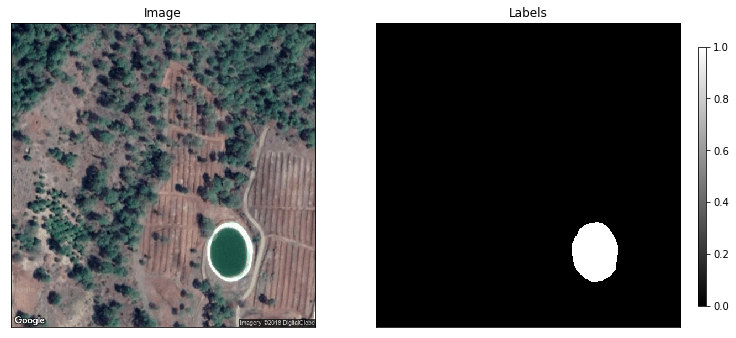

In [5]:
# This generator is only for display

# //-------------------------------------------------------------\\

im_prep_funcs = ['scaling']
im_prep_params = {}

labels_prep_funcs = ['pick channels']
labels_prep_params = {'idxs_channel': 0}

input_parameters = {'ims_paths': validation_ims_paths,
                    'labels_paths' : labels_paths,
                    'batch_size' : batch_size,
                    'n_classes' : n_classes,
                    'shuffle' : shuffle,
                    'im_prep_funcs' : im_prep_funcs,
                    'im_prep_params': im_prep_params,
                    'labels_prep_funcs' : labels_prep_funcs,
                    'labels_prep_params' : labels_prep_params}

tmp_generator = DataGenerator(**input_parameters)

# Display the above image
X, y = tmp_generator[index]
y = y.reshape(tmp_generator.batch_size, 
              tmp_generator.h, 
              tmp_generator.w, 
              tmp_generator.n_classes)

display_image_and_labels(X[0], y[0,...,1], colormap='gray')

# //-------------------------------------------------------------\\

In [6]:
# Load the trained model

# //-------------------------------------------------------------\\

# Input parameters

# Model to restore
weights_id = '2018-11-23_20_28_57'

weights_path = f'../neural_network/Model/{weights_id}/weights.h5'

# //-------------------------------------------------------------\\

# Restore the trained model
input_shape = (validation_images.h, 
               validation_images.w, 
               validation_images.channels)
model = restore_model(input_shape, n_classes, weights_path)
model.summary()

# //-------------------------------------------------------------\\















Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 512, 512, 3)  0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 518, 518, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 256, 256, 64) 9472        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 256, 256, 64) 256         conv1[0][0]                      
______________________________________________________________________________

In [7]:
# This is only for display

# //-------------------------------------------------------------\\

im_prep_funcs = ['zero padding']
im_prep_params = {'pad_size':20}

tmp_processor = ImagePreprocessing(im_prep_funcs, im_prep_params)

# //-------------------------------------------------------------\\

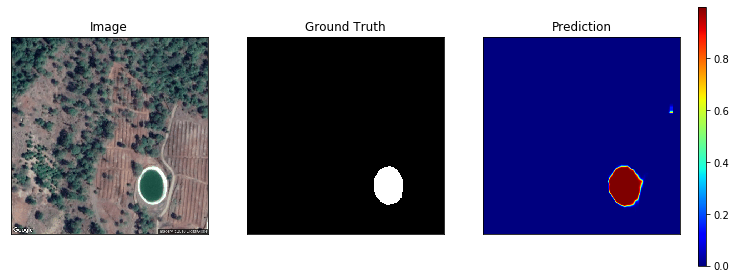

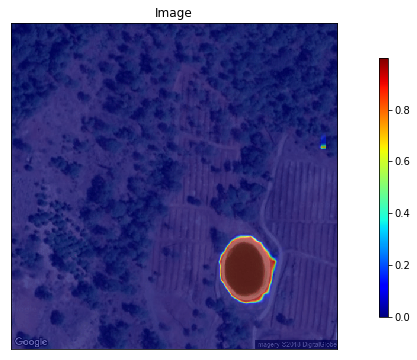

In [8]:
# Make one prediction

# //-------------------------------------------------------------\\

# Get the data
X, y = validation_images[index]
y = y.reshape(validation_images.batch_size, 
              validation_images.h, 
              validation_images.w, 
              validation_images.n_classes)

X_tmp, y_tmp = tmp_generator[index]
y_tmp = y_tmp.reshape(tmp_generator.batch_size, 
                      tmp_generator.h, 
                      tmp_generator.w, 
                      tmp_generator.n_classes)


# Prediction
y_pred = model.predict(X).reshape(validation_images.batch_size, 
                                  validation_images.h, 
                                  validation_images.w, 
                                  validation_images.n_classes)

# Show me baby ;)
display_image_labels_and_prediction(X_tmp[0,...,:3], 
                                    y_tmp[0,...,1], 
                                    tmp_processor(y_pred[0,...,1]))

display_overlap_images(X_tmp[0,...,:3], tmp_processor(y_pred[0,...,1]))

# //-------------------------------------------------------------\\

Current batch: 919


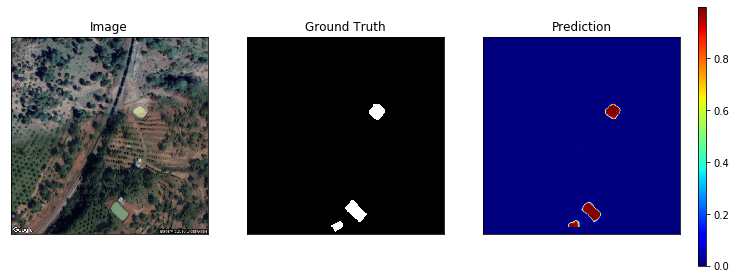

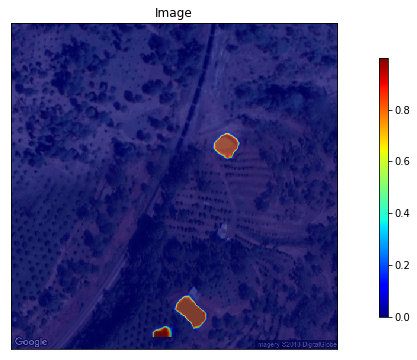

Current batch: 912


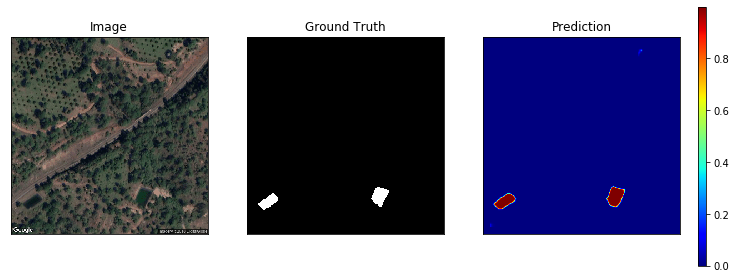

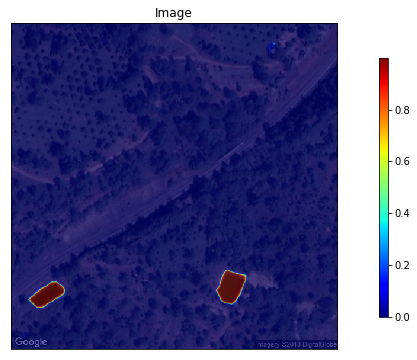

Current batch: 353


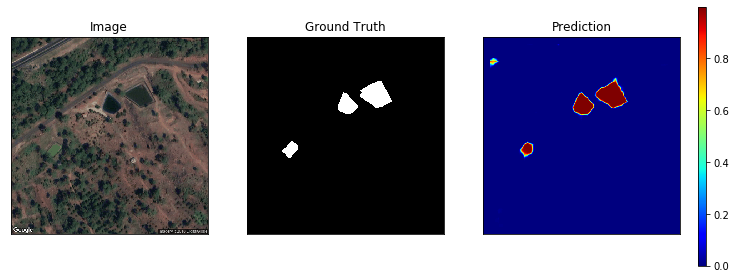

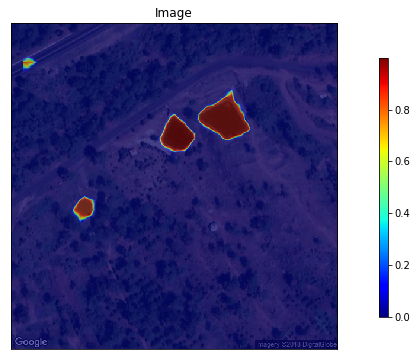

Current batch: 582


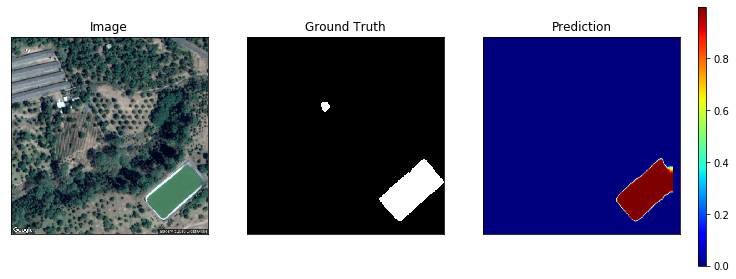

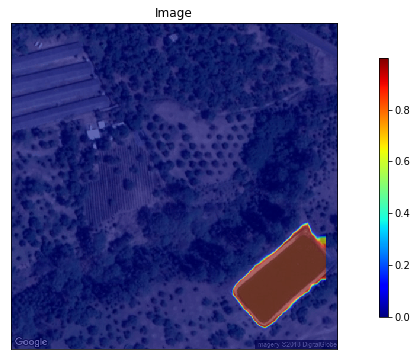

Current batch: 675


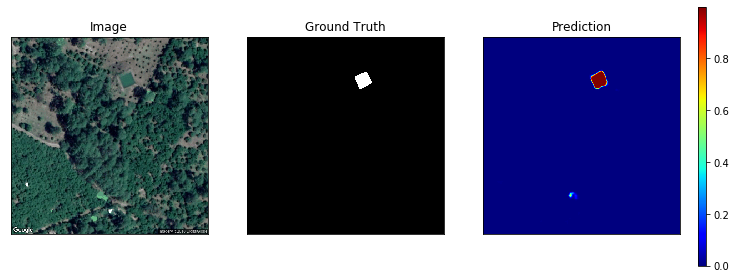

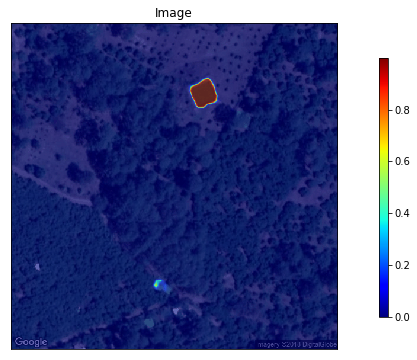

Current batch: 394


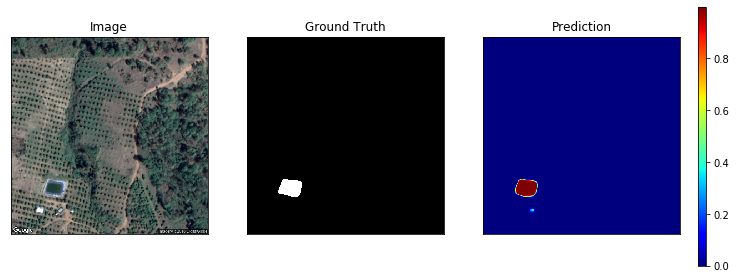

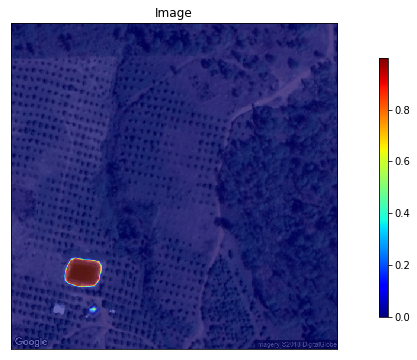

Current batch: 210


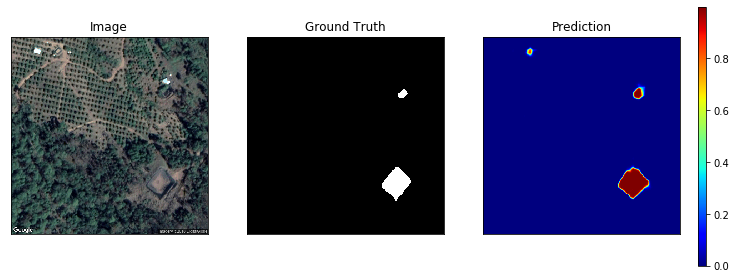

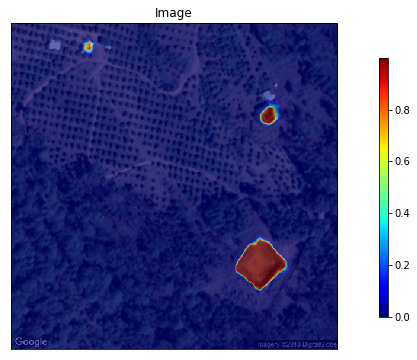

Current batch: 214


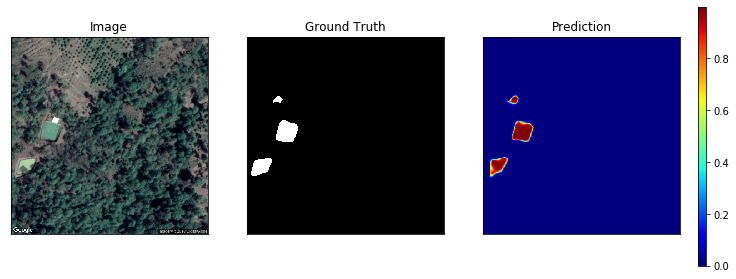

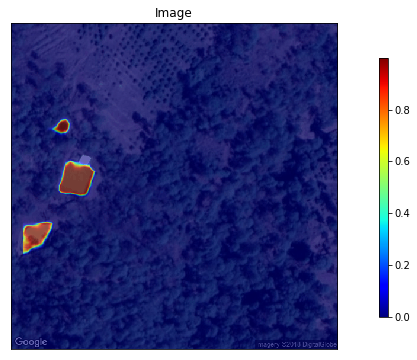

Current batch: 1490


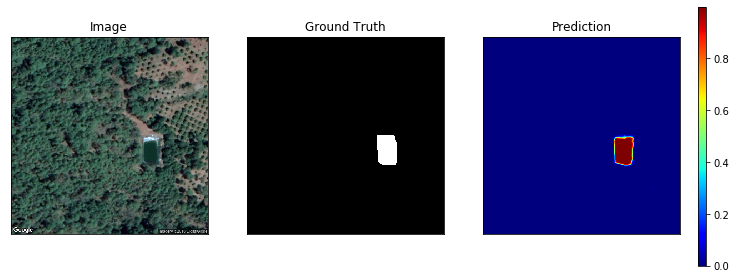

Current batch: 1560


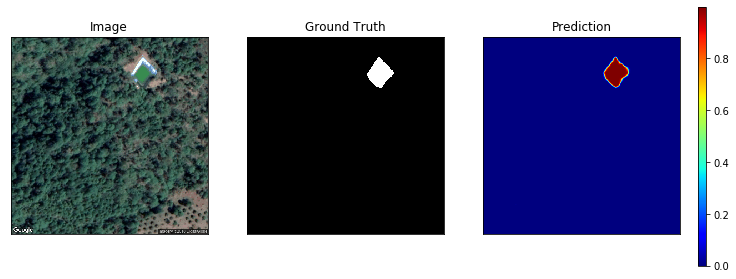

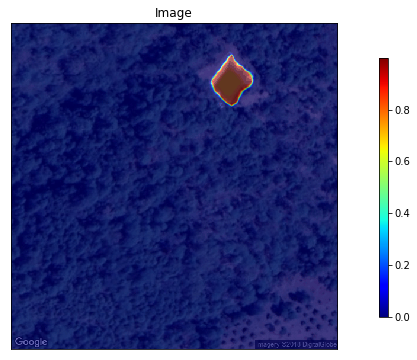

Current batch: 128


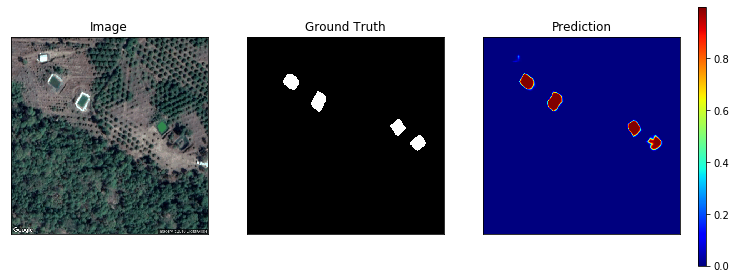

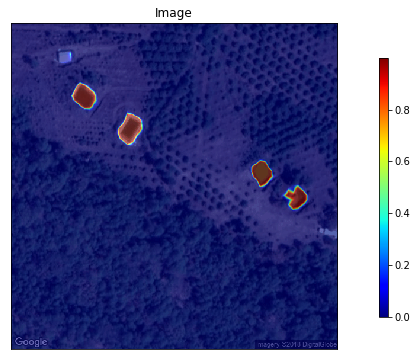

Current batch: 958


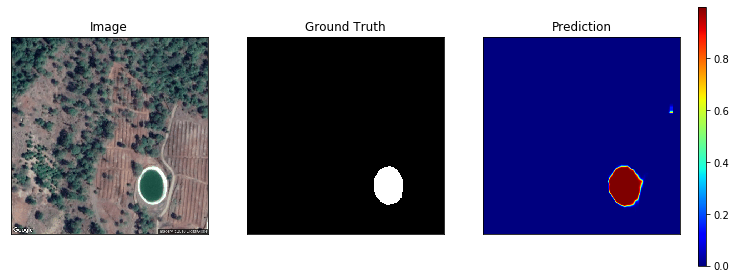

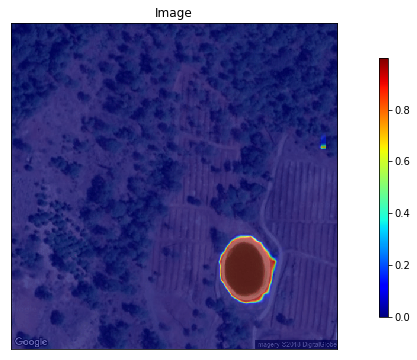

Current batch: 1302


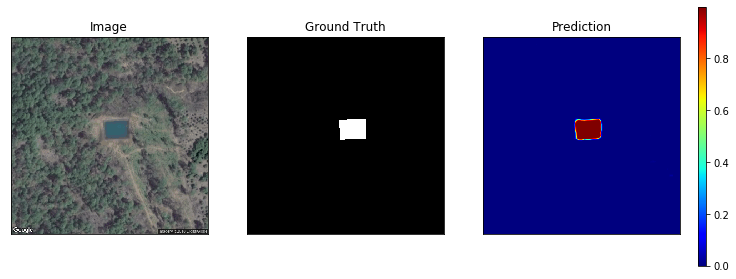

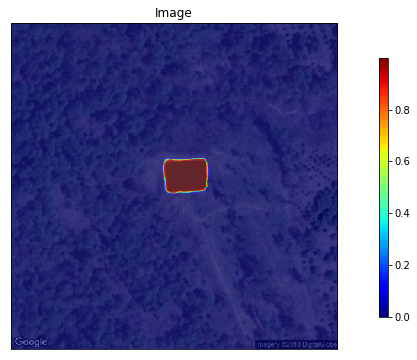

Current batch: 1386


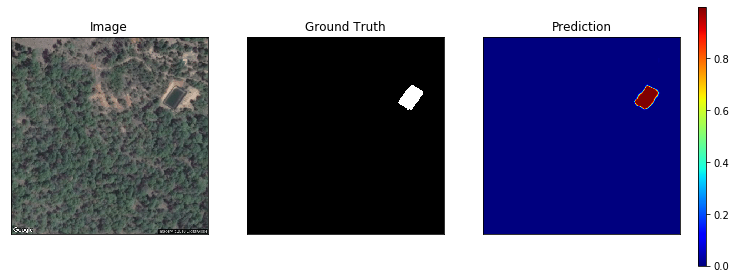

In [9]:
# Pass the whole dataset

# //-------------------------------------------------------------\\

# Input parameters

# Saving predictions
save_predictions = False
prediction_suffix = '_prediction.png'

# Creating an output directory with the model ID
# to store the predictions
output_path = '../Outputs/Validation_Images/predictions'
if not os.path.exists(output_path):
    os.mkdir(output_path)

output_path = os.path.join(output_path, weights_id)
if not os.path.exists(output_path):
    os.mkdir(output_path)

# //-------------------------------------------------------------\\

# Just pass some samples
idxs = [919, 912, 353, 582, 675, 394, 210, 214, 1490, 1560, 128, 958, 1302, 1386]

# for i in range(len(validation_images)):

for i in idxs:

    print(f'Current batch: {i}')    
    X, y = validation_images[i]

    X_tmp, y_tmp = tmp_generator[i]
    y_tmp = y_tmp.reshape(tmp_generator.batch_size, 
                          tmp_generator.h, 
                          tmp_generator.w, 
                          tmp_generator.n_classes)

    # Make prediction
    y_pred = model.predict(X).reshape(validation_images.batch_size, 
                                      validation_images.h, 
                                      validation_images.w, 
                                      validation_images.n_classes)
    
    for j in range(y_pred.shape[0]):
        
        if save_predictions:
            # Create an output directory for each image
            direct, im_name = os.path.split(validation_images.batch_ims_paths[j])
            p = os.path.join(output_path, os.path.basename(direct))            
            if not os.path.exists(p):
                os.mkdir(p)                        
            output_name = os.path.join(p, im_name.replace(data_suffix,
                                                          prediction_suffix))
            # Save
            with warnings.catch_warnings():
                warnings.simplefilter('ignore')
                imsave(output_name, y_pred[j,...,1])
       
        # Display the prediction
        if validation_images.labels_paths is None:
            display_image_and_labels(X_tmp[j,...,:3],
                                     tmp_processor(y_pred[j,...,1]), colormap='jet')
        else:
            display_image_labels_and_prediction(X_tmp[j,...,:3], 
                                                y_tmp[j,...,1], 
                                                tmp_processor(y_pred[j,...,1]))
        display_overlap_images(X_tmp[j,...,:3], 
                               tmp_processor(y_pred[j,...,1]))
    
if save_predictions:
    print(f'\nPredictions saved at: {output_path}\n')

# //-------------------------------------------------------------\\